# Lab 4: Transformer

## Transformer architecture for language machine translation

![](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

Transformer is a model architecture that was introduced in the paper "Attention is All You Need" by Vaswani et al. It's primarily used for natural language processing tasks such as language translation and text summarization. However, the first incarnation of this model was designed for machine translation. The Transformer model follows an encoder-decoder architecture, where the input is passed through an encoder to obtain a context representation, and then the context representation is passed through a decoder to generate the output. The Transformer model is based on self-attention mechanism, a mechanism that helps the model focus on the relevant parts of the input sequence as needed.
Such architecture has been used in many NLP tasks as well as in computer vision tasks or any other task requiring multi-modal inputs in form of a sequence. IN this lab we will see how to use the transformer architecture for sentiment analysis and text summarization.

### Multi-head attention

![](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

Transformer architecture implements a new kind of primitive operation called attention. An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.
In particular, multi-head attention consists of several attention heads, each one uses scaled dot-product attention mechanism. Each head takes the same input (query, key, value) and applies a linear transformation to project the input into different subspaces. The outputs of the different heads are concatenated and then projected again to obtain the final output.

### Scaled dot product attention

![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

Considering each head in the multi-head attention mechanism, the scaled dot product attention computes the dot product of the query with all keys, divide each by the square root of the depth of the key, and apply a softmax function to obtain the weights. The output is the weighted sum of the values.

# Sentiment analysis with transformer

In this lab we will use the transformer architecture to perform sentiment analysis on the IMDB dataset. The IMDB dataset contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews. Such dataset has been used in one of the previous labs to perform sentiment analysis with a simple neural network. In this lab we will use the transformer architecture to perform the same task, but with a more complex model.

In [17]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  13.8M      0  0:00:05  0:00:05 --:--:-- 16.7M


In [3]:
!cat aclImdb/train/pos/6248_7.txt

Being an Austrian myself this has been a straight knock in my face. Fortunately I don't live nowhere near the place where this movie takes place but unfortunately it portrays everything that the rest of Austria hates about Viennese people (or people close to that region). And it is very easy to read that this is exactly the directors intention: to let your head sink into your hands and say "Oh my god, how can THAT be possible!". No, not with me, the (in my opinion) totally exaggerated uncensored swinger club scene is not necessary, I watch porn, sure, but in this context I was rather disgusted than put in the right context.<br /><br />This movie tells a story about how misled people who suffer from lack of education or bad company try to survive and live in a world of redundancy and boring horizons. A girl who is treated like a whore by her super-jealous boyfriend (and still keeps coming back), a female teacher who discovers her masochism by putting the life of her super-cruel "lover" 

In [4]:
!rm -r aclImdb/train/unsup

In [18]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from transformer_utils import custom_preprocessing, plot_history

import os
import pickle
from datasets import load_dataset
import numpy as np
from transformer_utils import custom_preprocessing, plot_history

The first step is to load the dataset and preprocess it. We will use the `text_dataset_from_directory` utility provided by Keras to load the dataset. This utility will create a `tf.data.Dataset` object from text files in a directory. We will use this utility to load the training, validation, and test datasets. We will also preprocess the text by removing the HTML tags and converting the text to lowercase.

In [6]:
batch_size = 128
raw_train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.5,
    subset="training",
    seed=1337,
)
raw_val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.5,
    subset="validation",
    seed=1337,
)
raw_test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

print(f"Number of batches in raw_train_ds: {raw_train_ds.cardinality()}")
print(f"Number of batches in raw_val_ds: {raw_val_ds.cardinality()}")
print(f"Number of batches in raw_test_ds: {raw_test_ds.cardinality()}")


Found 25000 files belonging to 2 classes.
Using 12500 files for training.
Found 25000 files belonging to 2 classes.
Using 12500 files for validation.
Found 25000 files belonging to 2 classes.
Number of batches in raw_train_ds: 98
Number of batches in raw_val_ds: 98
Number of batches in raw_test_ds: 196


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I gave this a four purely out of its historical context. It was considered lost for many years until it popped up out of the blue on Showtime in the early nineties.<br /><br />Moe is the straight man and Larry and Curly act as a duo. Spade Cooley has a couple of numbers. I guess it had something to do with working on a ranch. I'm not quite sure because the plot was so minimal nothing really sticks in my memory. I vaguely remember it being a western musical comedy. Even the Stooge's seem to be going through the motions. Overall there's nothing much really to recommend here.<br /><br />If you're not a Stooge fan then don't bother. If you are a Stooge fan, then stick with the shorts."
0
b'First than anything, I\'m not going to praise I\xc3\xb1arritu\'s short film, even I\'m Mexican and proud of his success in mainstream Hollywood.<br /><br />In another hand, I see most of the reviews focuses on their favorite (and not so) short films; but we are forgetting that there is a subtle bottom 

In order to process the text data, we need to convert the text into a sequence of integers. To do this, we will use the `TextVectorization` layer provided by Keras. This layer will preprocess the text by removing punctuation and splitting it into words. It will then convert the words into integers. We will use this layer to preprocess the text data and convert it into a sequence of integers. We will also pad the sequences so that they all have the same length.

In [8]:
vectorize_layer = keras.layers.TextVectorization(
    standardize=custom_preprocessing,
    max_tokens=20000,
    output_mode="int",
    output_sequence_length=500,
)

text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [9]:
a,b = next(iter(raw_train_ds))
print(a)
print(b)

tf.Tensor(
[b'OK, so the musical pieces were poorly written and generally poorly sung (though Walken and Marner, particularly Walken, sounded pretty good). And so they shattered the fourth wall at the end by having the king and his nobles sing about the "battle" with the ogre, and praise the efforts of Puss in Boots when they by rights shouldn\'t have even known about it.<br /><br />Who cares? It\'s Christopher Freakin\' Walken, doing a movie based on a fairy tale, and he sings and dances. His acting style fits the role very well as the devious, mischievous Puss who seems to get his master into deeper and deeper trouble but in fact has a plan he\'s thought about seven or eight moves in advance. And if you\'ve ever seen Walken in any of his villainous roles, you *know* the ogre bit the dust HARD at the end when Walken got him into his trap.<br /><br />A fun film, and a must-see for anyone who enjoys the unique style of Christopher Walken.'
 b"To a certain extent, I actually liked this f

In [10]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [11]:
a,b = next(iter(train_ds))
print(a)
print(b)

tf.Tensor(
[[   99     2 19491 ...  2093     1   220]
 [   10   275   565 ...     0     0     0]
 [   14   986    14 ...     0     0     0]
 ...
 [   11    44   180 ...     0     0     0]
 [    1     7  1575 ...     0     0     0]
 [    2    17     7 ...     0     0     0]], shape=(128, 500), dtype=int64)
tf.Tensor(
[1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1
 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1
 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1
 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1], shape=(128,), dtype=int32)


In [12]:
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)
test_ds = test_ds.cache().prefetch(buffer_size=10)

Once the text data has been preprocessed to be suitable for being fed to the neural network. The transformer model consists of an embedding layer, a transformer block, and a classifier:
   * The embedding layer is used to convert the integer sequences into dense vectors.
   * The transformer block is the core of the transformer model. It consists of multiple transformer layers, each of which consists of a multi-head self-attention layer and a feedforward neural network.
   * The classifier is a dense layer that is used to classify the input sequence.

In [13]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, model_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.model_size = model_size

        assert model_size % self.num_heads == 0

        self.depth = model_size // self.num_heads

        self.wq = tf.keras.layers.Dense(model_size)
        self.wk = tf.keras.layers.Dense(model_size)
        self.wv = tf.keras.layers.Dense(model_size)

        self.dense = tf.keras.layers.Dense(model_size)

    def split_heads(self, x, batch_size):

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(output, (batch_size, -1, self.model_size))

        output = self.dense(concat_output)

        return output


In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


In [15]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):

        maxlen = tf.shape(x)[-1]
        positions = tf.range(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

As any other model, also transformer model needs some hyperparameters to be set. In this case we need to set the vocabulary size, the maximum length of the input tokens, the embedding dimension, the number of attention heads, the hidden layer size in the feed forward network inside the transformer.

In [16]:
vocab_size = 20000
maxlen = 500
embed_dim = 32
num_heads = 16
ff_dim = 64

In [17]:
def get_transformer_model():
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model = get_transformer_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 token_and_position_embeddi  (None, 500, 32)           656000    
 ng (TokenAndPositionEmbedd                                      
 ing)                                                            
                                                                 
 transformer_block (Transfo  (None, 500, 32)           71424     
 rmerBlock)                                                      
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

Finally, the model has to be compiled and trained. We will use the Adam optimizer and the sparse categorical crossentropy loss function.

In [19]:
class SaveCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=1, save_path_weights=f'./model_weights/weights_img.weights.h5', save_path_history=f'./model_history/history_img.pkl'):
        super(SaveCallback, self)
        self.epoch_interval = epoch_interval
        self.save_path = save_path_weights
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.save_path_history = save_path_history


    def on_epoch_end(self, epoch, logs={}):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self.model.save_weights(self.save_path)
            self.train_loss_history.append(logs['loss'])
            self.train_acc_history.append(logs['accuracy'])
            if 'val_loss' in logs and 'val_accuracy' in logs:
              self.val_loss_history.append(logs['val_loss'])
              self.val_acc_history.append(logs['val_accuracy'])
            history = {'loss': self.train_loss_history,
                       'val_loss': self.val_loss_history,
                       'accuracy': self.train_acc_history,
                       'val_accuracy': self.val_acc_history}
            with open(self.save_path_history, 'wb') as f:
                pickle.dump(history, f)


save_callback = SaveCallback(epoch_interval=1, save_path_weights='classification_transformer_model.weights.h5', save_path_history='classification_transf_history.pkl' )

In [20]:
training = False
load_weights = True
epochs = 3
weights_file_exists = os.path.exists('classification_transformer_model.weights.h5')
pickle_file_exists = os.path.exists('classification_history.pkl')

if load_weights and weights_file_exists:
    model.load_weights('classification_transformer_model.weights.h5', skip_mismatch=True)

opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

if training:
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[save_callback])
    model.save('classification_transformer_model.weights.h5')
    with open('classification_history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
elif load_weights and pickle_file_exists:
    with open('classification_history.pkl', 'rb') as f:
        history = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:333: UserWarning: Could not load weights in object <keras.src.engine.functional.Functional object at 0x7afd541cd4e0>. Skipping object. Exception encountered: "Unable to synchronously open object (object 'vars' doesn't exist)"
  _load_state(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:457: UserWarning: Could not load weights in object <keras.src.layers.core.embedding.Embedding object at 0x7afd543790c0>. Skipping object. Exception encountered: Layer 'embedding' expected 1 variables, but received 0 variables during loading. Expected: ['token_and_position_embedding/embedding/embeddings:0']
  _load_state(
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:457: UserWarning: Could not load weights in object <keras.src.layers.core.embedding.Embedding object at 0x7afd58591e40>. Skipping object. Exception encountered: Layer 'embedding_1' expected 1 variables, but received 0 varia

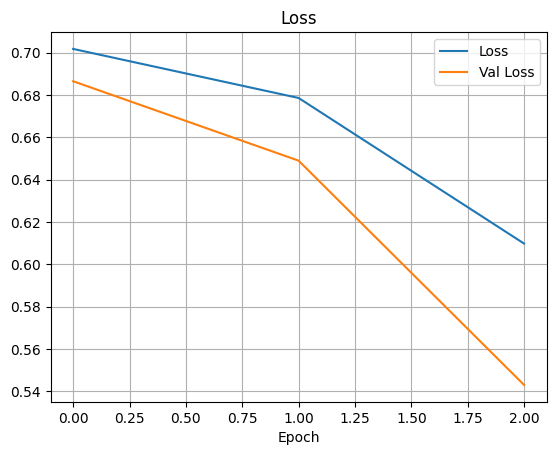

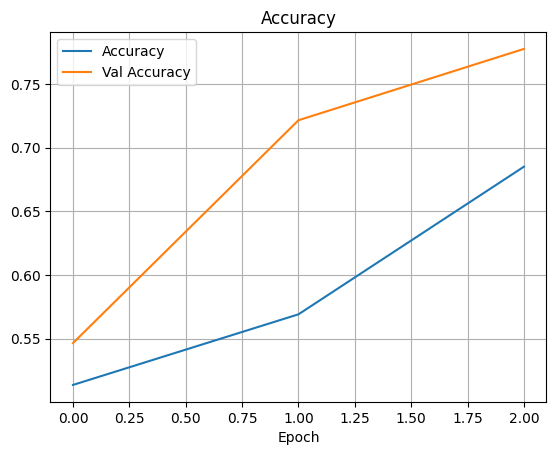

In [21]:
loss_history = history.history['loss'] if training and pickle_file_exists else history['loss']
val_loss_history = history.history['val_loss'] if training and pickle_file_exists else history['val_loss']

acc_history = history.history['accuracy'] if training and pickle_file_exists else history['accuracy']
val_acc_history = history.history['val_accuracy'] if training and pickle_file_exists else history['val_accuracy']

plot_history(loss_history, val_loss_history, 'Loss')
plot_history(acc_history, val_acc_history, 'Accuracy')

In order to evaluate the model, we can use the test set. This method will evaluate the model on the test dataset and return the loss and accuracy.

In [22]:
model.evaluate(test_ds)# !!!!!!!!

196/196 [==============================] - 1760s 9s/step - loss: 0.7209 - accuracy: 0.5000


[0.7208744287490845, 0.5]

# Text generation with transformer

In this lab we will use the transformer architecture to generate text. We will use the simplebooks-92 dataset, which contains text from 92 books in the public domain. The dataset contains a total of 1.3 million lines of text. We will use this dataset to train a transformer model to generate text. We will use the transformer model to generate text by sampling from the model's output distribution. We will use different sampling strategies to generate text, such as greedy search, beam search, random search, top-k search, and top-p search.

In [2]:
!pip install -q --upgrade keras-hub
!pip install -q --upgrade keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [3]:
import os
import keras_hub
import keras
import pickle

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

Compared with the way we loaded the in the first class, the current example employs raw text data. So, since the deep learning models deal with numerical data, a pre-processing stage is necessary.  

In [4]:
# Data
BATCH_SIZE = 64
MIN_STRING_LEN = 512  # Strings shorter than this will be discarded
SEQ_LEN = 128  # Length of training sequences, in tokens

# Model
EMBED_DIM = 256
FEED_FORWARD_DIM = 128
NUM_HEADS = 3
NUM_LAYERS = 2
VOCAB_SIZE = 5000  # Limits parameters in model.

# Training
EPOCHS = 5

# Inference
NUM_TOKENS_TO_GENERATE = 80


In [5]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
)
dir = os.path.expanduser("./simplebooks/simplebooks")

# Load simplebooks-92 train set and filter out short lines.
raw_train_ds = (
    tf_data.TextLineDataset(os.path.join(dir, "simplebooks-92-raw", "train.txt"))
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE)
    .shuffle(buffer_size=256)
)

# Load simplebooks-92 validation set and filter out short lines.
raw_val_ds = (
    tf_data.TextLineDataset(os.path.join(dir, "simplebooks-92-raw", "valid.txt"))
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE)
)


282386239/282386239 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [6]:
!cp -r ~/.keras/datasets/simplebooks.zip ./simplebooks

In the first lecture, we have seen a way to create the vocabulary, this time we will rely on some utilities provided by Keras. However, the routine to create the vocabulary is not dissimilar to the one presented in the first class.

In [7]:
if os.path.exists("vocab.pkl"):
    with open('vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
else:
# Train tokenizer vocabulary
    vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
        raw_train_ds,
        vocabulary_size=VOCAB_SIZE,
        lowercase=True,
        reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
    )
    with open('vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)

Considering that the dataset is composed of raw text data, we need to tokenize it. The tokenization process is done by the `WordPieceTokenizer` utility provided by Keras. This process will take account of subset of words in the vocabulary adding some reserved tokens where needed. For instance the `[BOS]` token is added to the beginning of the text data or the `[UNK]` token is added to the text data when the word is not in the vocabulary. Moreover, during the tokenization process, the numer of considered tokens is chosen according to the model's input size.

In [8]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)


Since the dataset called simplebooks-92 is composed of clean data, it does not undergo through heavy pre-processing. The only pre-processing step is to tokenize the text data other than the addition of the `[BOS]` token at the beginning of the tokenized data.

In [9]:
# packer adds a start token
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)


def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)



The model we can see below is a simplified GPT model using a sequence of decoder blocks with self-attention. The model is composed of an embedding layer, a transformer decoder, and a dense layer.
The embedding layer is used to convert the integer sequences into dense vectors. Then, the transformer decoder through multi-head self-attention layers summarizes the information in the text into a lower dimesional space. Finally, the dense layer is used to predict which is the next token in the sequence.

In [10]:
inputs = keras.layers.Input(shape=(None,), dtype="int32")
# Embedding.
embedding_layer = keras_hub.layers.TokenAndPositionEmbedding(
    vocabulary_size=VOCAB_SIZE,
    sequence_length=SEQ_LEN,
    embedding_dim=EMBED_DIM,
    mask_zero=True,
)
x = embedding_layer(inputs)
# Transformer decoders.
for _ in range(NUM_LAYERS):
    decoder_layer = keras_hub.layers.TransformerDecoder(
        num_heads=NUM_HEADS,
        intermediate_dim=FEED_FORWARD_DIM,
    )
    x = decoder_layer(x)  # Giving one argument only skips cross-attention.
# Output.
outputs = keras.layers.Dense(VOCAB_SIZE)(x)
model = keras.Model(inputs=inputs, outputs=outputs)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
perplexity = keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer="adam", loss=loss_fn, metrics=[perplexity])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 256)           │       1,312,768 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder                  │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_decoder_1                │ (None, None, 256)           │         329,085 │
│ (TransformerDecoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 5000)          │       1,285,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,255,938 (12.42 MB)

 Trainable params: 3,255,938 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class SaveCallback(keras.callbacks.Callback):
    def __init__(self, epoch_interval=1, save_path_weights=f'./model_weights/weights_trs.weights.h5', save_path_history=f'./model_history/history_trs.pkl'):
        super(SaveCallback, self)
        self.epoch_interval = epoch_interval
        self.save_path = save_path_weights
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.save_path_history = save_path_history


    def on_epoch_end(self, epoch, logs={}):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self.model.save_weights(self.save_path)
            self.train_loss_history.append(logs['loss'])
            self.train_acc_history.append(logs['perplexity'])
            if 'val_loss' in logs and 'val_perplexity' in logs:
              self.val_loss_history.append(logs['val_loss'])
              self.val_acc_history.append(logs['val_perplexity'])
            history = {'loss': self.train_loss_history,
                       'val_loss': self.val_loss_history,
                       'perplexity': self.train_acc_history,
                       'val_perplexity': self.val_acc_history}
            with open(self.save_path_history, 'wb') as f:
                pickle.dump(history, f)


save_callback = SaveCallback(epoch_interval=1, save_path_weights='generation_transformer_model.weights.h5', save_path_history='generation_transf_history.pkl' )

So, the model subside to the training phase by evaluating the training through the perplexity metric.
The perplexity metric is a measure of how well a probability model predicts a sample, where a low perplexity indicates the model is good at predicting the sample.

**Definition**:

Perplexity is defined as the exponentiated average negative log-likelihood of a sequence. If we have a tokenized sequence $X=(x_0,x_1,…,x_t)$, then the perplexity of $X$ is,

$$

\text{PPL}(X) = \exp\left(-\frac{1}{t}\sum_{i=0}^{t}\log p_\theta(x_i|x_{<i})\right)

$$

In [14]:
training = False
load_weights = True
epochs = 3
weights_file_exists = os.path.exists('generation_transformer_model.weights.h5')
pickle_file_exists = os.path.exists('generation_transf_history.pkl')

if load_weights and weights_file_exists:
    model.load_weights('generation_transformer_model.weights.h5', skip_mismatch=True)

opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss=loss_fn, metrics=[perplexity])

if training:
    generation_history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[save_callback]).history
    model.save('generation_transformer_model.weights.h5')
    with open('generation_history.pkl', 'wb') as f:
        pickle.dump(generation_history, f)
elif load_weights and pickle_file_exists:
    with open('generation_transf_history.pkl', 'rb') as f:
        generation_history = pickle.load(f)

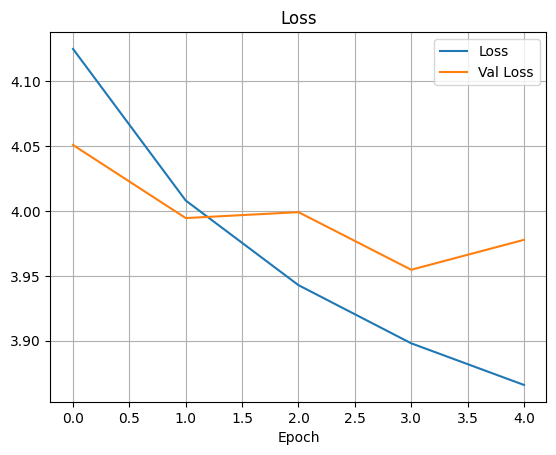

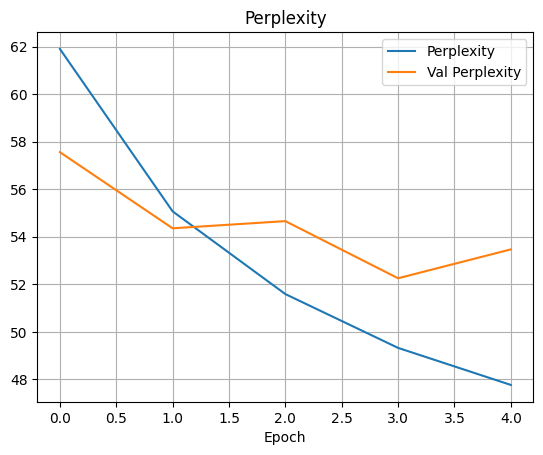

In [19]:
loss_history = generation_history['loss']
val_loss_history = generation_history['val_loss']
perplexity_history = generation_history['perplexity']
val_perplexity_history = generation_history['val_perplexity']

plot_history(loss_history, val_loss_history, 'Loss')
plot_history(perplexity_history, val_perplexity_history, 'Perplexity')

Generative models are meant to learn the distribution of the data and generate new samples from that distribution.
In this case, the model is trained to predict the next token in the sequence. The model can be used to generate text by sampling from the output distribution. We will use different sampling strategies to generate text, such as greedy search, beam search, random search, top-k search, and top-p search.

In [20]:
# The "packer" layers adds the [BOS] token for us.
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

<tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>

In [21]:
def next(prompt, cache, index):
    logits = model(prompt)[:, index - 1, :]
    # Ignore hidden states for now; only needed for contrastive search.
    hidden_states = None
    return logits, hidden_states, cache


In [22]:
sampler = keras_hub.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.

Greedy search generated text: 
['[BOS] " i am not going to be in the way of the world , " said the old man , " and i am going to be a man , and i am going to be a man , and i am going to be a man . i am going to be a man , and i am going to be a man , and i am going to be a man . i am going to be a man , and i am going to be a man , and i am going to be a man . i am going to be a man , and i am going to be a man , and i am going to be a man . i']


In [23]:
sampler = keras_hub.samplers.BeamSampler(num_beams=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")


Beam search generated text: 
['[BOS] " oh , yes , " she said , " i don \' t know what to do . i don \' t know anything about it , but i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do . i don \' t know what to do']


In [24]:
sampler = keras_hub.samplers.RandomSampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Random search generated text: \n{txt}\n")


Random search generated text: 
['[BOS] king arthur lost allangarians for their rights when the desert horse might return the horse by his old followers that guarded , the earl of . they were believed on the top . being a block of wood by sea , for ships were made very astonished when the transport of the bargain hundreds of white men became bigger and consumes once more a battle towards the stream . these seas were now towed organise ground , and several men , frowned , pressed forward against the rock , began palm and learned in such a manner that each huge combatants looked up as if they wished to die']


In [25]:
sampler = keras_hub.samplers.TopKSampler(k=10)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")


Top-K search generated text: 
['[BOS] the next day , however , there may be , for in the morning . the weather has changed its cold and weather ; but now , it is necessary that it should be necessary to the southeaster southeast . there is nothing to be seen of the country ; and the changing the road from the north ; the country will be in the mountains that this country is , and they may be in the district of america . there are many of them who have no means to spend their money on the hills . they may have been abundant for them , and the country is now very well known , but as the country']


In [26]:
sampler = keras_hub.samplers.TopPSampler(p=0.5)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")


Top-P search generated text: 
['[BOS] the peasants and people \' s courtes were all of these who had been used to transport . in the morning the monks were about to represent a fire . the chief was in the bragil , and the young men were seated on the front of the table , and was reinforced by the radio . they had a hearty welcome , and had received the offers of their guests , and the young people were brought into the hall , and the eldest had been approved , and he said to him , " i will tell you . " [PAD]']


Exercises:
1. Implement the test set evaluation for the generative model.
2. Use the model we used in the first class for the classification task employing same the dataset and compare the results.
3. (Optional) Try to improve the performance of the second model by training it for longer and/or using another dataset to fine-tune it.

All the files used in this lab can be found [here](https://liveunibo-my.sharepoint.com/:u:/g/personal/angelo_quarta2_unibo_it/EWvhdtQZssFJjQQi-QsWFYEBHZJSLldGEYvPGXdKc9QObw?e=lxe3oa)